In [1]:
import json
import csv
import tweepy
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from textblob import TextBlob
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize
from sklearn import metrics

In [2]:
def get_tweets(consumer_key, consumer_secret, access_token, access_token_secret, hashtag_phrase):
    #auth
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    
    #init tweepy
    api = tweepy.API(auth)
    
    #spreadsheet name to write to
    fname = '_'.join(re.findall(r"\w+", hashtag_phrase))
    with open('%s.csv' %(fname), 'w') as file:
        w = csv.writer(file)
        #header
        w.writerow(['timestamp','tweet_text','username', 'followers_count'])
        for tweet in tweepy.Cursor(api.search, q=hashtag_phrase+"-filter:retweets", lang="en", 
                                   tweet_mode="extended").items(2000):
            w.writerow([tweet.created_at,tweet.full_text.replace('\n',' ').encode('utf-8'), 
                        tweet.user.screen_name.encode('utf-8'), tweet.user.followers_count])
            
def clean_tweet(tweet): 
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def get_tweet_sentiment(tweet):
    analysis = TextBlob(clean_tweet(tweet))
    return analysis.sentiment.polarity

In [3]:
with open('api.json') as f:
    api = json.load(f)
consumer_key = api["Key"]
consumer_secret = api["Secret"]
access_token = api["Access Token"]
access_token_secret = api["Access Token Secret"]

hashtag_phrase = input('Hashtag Phrase ')

if __name__ == '__main__':
    get_tweets(consumer_key, consumer_secret, access_token, access_token_secret, hashtag_phrase)

Hashtag Phrase narendramodi BJP


In [4]:
df = pd.read_csv('narendramodi_BJP.csv')
df.head()

,timestamp,tweet_text,username,followers_count
0,2020-06-03 12:04:19,b'#gtu #BoycottGTUOfflineExams @narendramodi ...,b'JoshiMohit6',0
1,2020-06-03 12:04:17,b'@HRDMinistry @MIB_India @MIB_Hindi @PrakashJ...,b'SarvasvaTheGod',182
2,2020-06-03 12:03:49,b'The BJP responds. The people of Banaskanth...,b'HarjiChaudhary2',9
3,2020-06-03 12:03:06,"b""@DeccanHerald @drashwathcn @akramtalk you ar...",b'realsachinh',10
4,2020-06-03 12:02:06,b'@bold_views @ShivRajMathur1 @priyapyadav18 @...,b'mani24sjcpl',375


In [17]:
raw_tweets = df[['tweet_text', 'followers_count']]
tweets = []
for ind in df.index:
    parsed_tweets = {}
    text = df['tweet_text'][ind]
    parsed_tweets['sentiment'] = get_tweet_sentiment(text)
    parsed_tweets['followers'] = df['followers_count'][ind]
    tweets.append(parsed_tweets)
df2 = pd.DataFrame(tweets)
df2

,sentiment,followers
0,0.050000,0
1,0.150000,182
2,0.285714,9
3,0.200000,10
4,0.700000,375
...,...,...
1995,0.000000,577
1996,0.183333,847
1997,0.083333,771
1998,-0.150000,21


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df2)
X = normalize(X_scaled)
X

array([[-0.97171105, -0.23617288],
       [ 0.98770567, -0.15632498],
       [ 0.99880349, -0.04890384],
       ...,
       [-0.54823104, -0.83632693],
       [-0.99919727, -0.0400601 ],
       [-0.99432251, -0.10640844]])

In [16]:
db = DBSCAN(eps = 0.25, min_samples = 3).fit(X)
labels = db.labels_

In [8]:
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
n_clusters_ = len(set(labels))-(1 if -1 in labels else 0)
print(metrics.silhouette_score(X, labels))

0.8855452758043073


In [19]:
def get_tweet_polarity(tweet):
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [33]:
nT = len(df)
nP = 0
nM = 0
nN = 0
for row in df.index:
    text = df['tweet_text'][row][1:]
    if(get_tweet_polarity(text)=='positive'):
        nP = nP+1
    elif(get_tweet_polarity(text)=='negative'):
        nM = nM+1
    else:
        nN = nN+1

print("Positive tweets percentage: " + str(round(100*nP/nT, 2)) + "%")
print("Negative tweets percentage: "+ str(round(100*nM/nT, 2)) + "%")
print("Neutral tweets percentage: " + str(round(100*(nT-nP-nM)/len(tweets), 2)) + "%")

Positive tweets percentage: 46.3%
Negative tweets percentage: 21.85%
Neutral tweets percentage: 31.85%


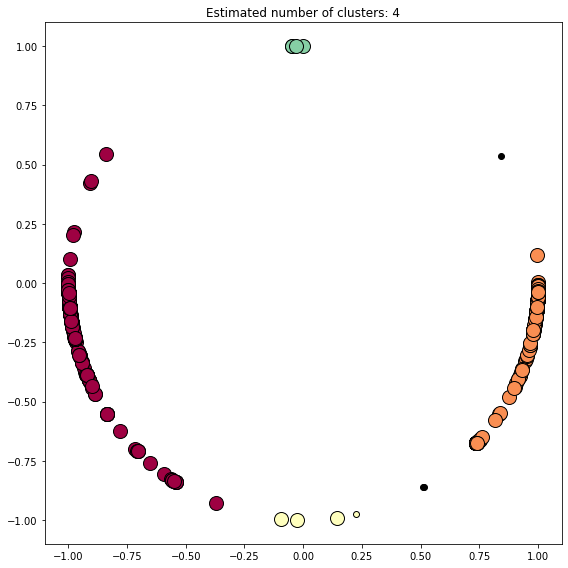

In [10]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize =(8, 8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.tight_layout()
plt.show()